# Lista Prática - Questão 1

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import display, display_html, display_markdown, display_svg, Markdown, HTML

from examples.seismic import Model, plot_velocity, TimeAxis, setup_geometry, RickerSource, AcquisitionGeometry
from devito import *
%matplotlib inline

## Parâmetros dos operadores de diferenças finitas

In [30]:
space_order=2

## Definição do modelo

### Dimensões do modelo

O modelo possuirá dimensões $w \times h = 1500 \mathrm{m} \times 1500 \mathrm{m}$, e um espaçamento de $\Delta x = \Delta z = 10$ m. Logo, a malha deverá ter 
$$
n_x = \frac{w}{\Delta x} + 1 = \frac{1500 \mathrm{m}}{10 \mathrm{m}} + 1 = 151
$$
pontos ao longo do eixo x e
$$
n_z = \frac{w}{\Delta z} + 1 = \frac{1500 \mathrm{m}}{10 \mathrm{m}} + 1 = 151
$$
pontos ao longo do eixo z.

Como a propagação irá durar

In [31]:
shape = (151, 151)
spacing = (10., 10.)
origin = (0., 0.)
nbl=325
# nbl=100

### Parâmetros físicos

In [32]:
v = 2.0 * np.ones(shape, dtype=np.float32) # Velocidade da onda P em km/s
rho = 2.0 * np.ones(shape, dtype=np.float32) # Densidade em g/cm^3

In [33]:
model = Model(vp=v, b=1/rho, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbl=nbl, bcs="damp")

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


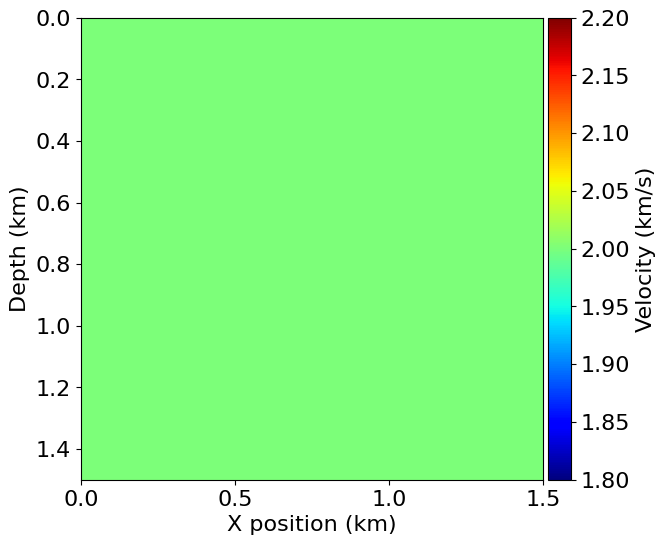

In [34]:
plot_velocity(model)

## Parâmetros da aquisição

### Tempo de aquisição

In [35]:
t0 = 100.  # ms
tn = 2000. # ms
# dt = model.critical_dt
dt = 2

time_range = TimeAxis(start=t0, stop=tn, step=dt)

### Geometria

In [ ]:
# Frequência de pico da fonte
f0 = 0.006

In [37]:
# geometry = setup_geometry(model, tn, f0=f0)
geometry = AcquisitionGeometry(model, np.array([[0,0]], dtype=model.dtype), np.array([[0,0]], dtype=model.dtype), t0, tn)
geometry.resample(dt)

In [38]:
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, :] = np.array(model.domain_size) * .5

#### Gráfico da fonte

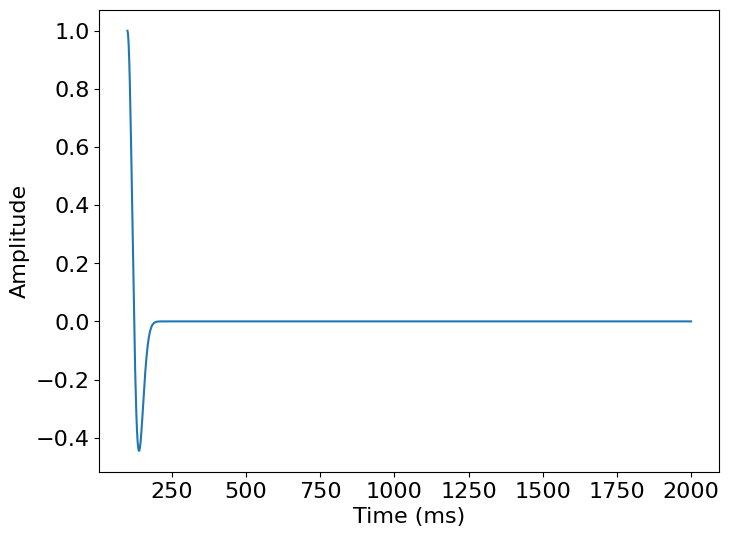

In [39]:
src.show()

#### Posição da fonte

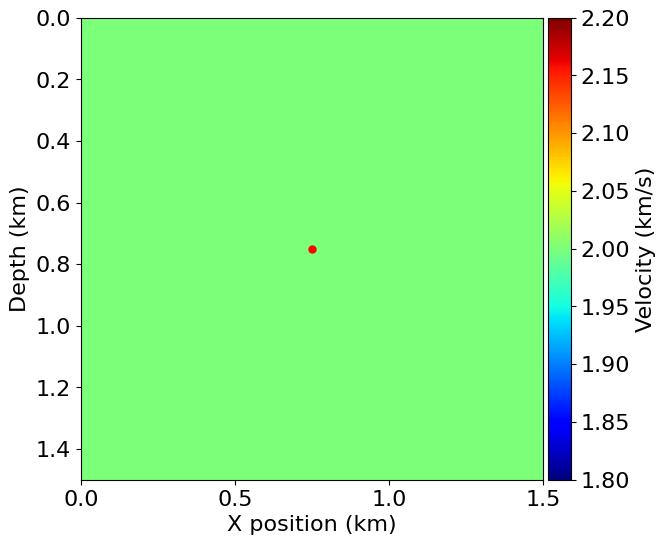

In [40]:
plot_velocity(model, source=src.coordinates.data)

## Resolução da alternativa a)

### Definição da equação da onda acústica de 2ª ordem

Aqui é definida no *Devito* a equação

$$
\frac{1}{v_P^2}\frac{\partial^2 P}{\partial t^2} - \rho \nabla \cdot \left( \frac{1}{\rho} \nabla P \right) = S
$$

em que:

- $P$ é o campo de pressão;
- $v_P$ é o campo de velocidade da onda P;
- $\rho$ é o campo de densidade;
- $S$ é o termo fonte;

In [41]:
# Função pra o campo de pressão
P = TimeFunction(name="P", grid=model.grid, time_order=2, space_order=space_order, save=geometry.nt, staggered=NODE)

In [42]:
vp = model.vp
rho = 1/model.b

In [43]:
# Equação da onda acústica de 2ª ordem
EDP = 1/vp**2 * P.dt2 - rho * div( 1/rho * grad(P, .5), -.5)
EDP

-(Derivative(b(x, y)*Derivative(P(time, x, y), x), x) + Derivative(b(x, y)*Derivative(P(time, x, y), y), y))/b(x, y) + Derivative(P(time, x, y), (time, 2))/vp(x, y)**2

In [44]:
# Expressão para o campo de ondas futuro, P(r, t + dt)
stencil = Eq(P.forward, solve(EDP, P.forward))
stencil

Eq(P(time + dt, x, y), dt**2*((Derivative(b(x, y)*Derivative(P(time, x, y), x), x) + Derivative(b(x, y)*Derivative(P(time, x, y), y), y))/b(x, y) - (-2.0*P(time, x, y)/dt**2 + P(time - dt, x, y)/dt**2)/vp(x, y)**2)*vp(x, y)**2)

In [45]:
# Símbolo do espaçamento temporal
s = model.grid.stepping_dim.spacing

# Expressão do termo fonte a ser injetada no stencil criado acima
src_term = src.inject(field=P.forward, expr=src * s**2 * vp**2)

### Criação do operador de diferenças finitas

In [46]:
# Criação do operador do Devito
op = Operator([stencil] + src_term, subs=model.spacing_map)

In [47]:
# Execução
op(dt=dt)

Operator `Kernel` ran in 1.11 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1.1071379999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0005170000000000054, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [48]:
# NBVAL_IGNORE_OUTPUT

def plot(a, title=None):
    # Some useful definitions for plotting if nbl is set to any other value than zero
    shape_pad = np.array(shape) + 2 * nbl
    origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
    extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])
    # Note: flip sense of second dimension to make the plot positive downwards
    plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
                origin_pad[1] + extent_pad[1], origin_pad[1]]
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(np.abs(a.data[kt, :, :]))

    nsnaps = 5
    factor = round(time_range.num / nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
    fig.suptitle(title, size=15)
    for count, ax in enumerate(axes.ravel()):
        snapshot = factor * (count + 1)
        ax.imshow(np.transpose(a.data[snapshot, :, :]), cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(src.coordinates.data[0, 0], src.coordinates.data[0, 1], 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("Wavefield at t=%.2fms" % (factor*(count + 1)*dt + t0), fontsize=10)
        ax.set_xlabel("X Coordinate (m)", fontsize=10)
        ax.set_ylabel("Z Coordinate (m)", fontsize=10)

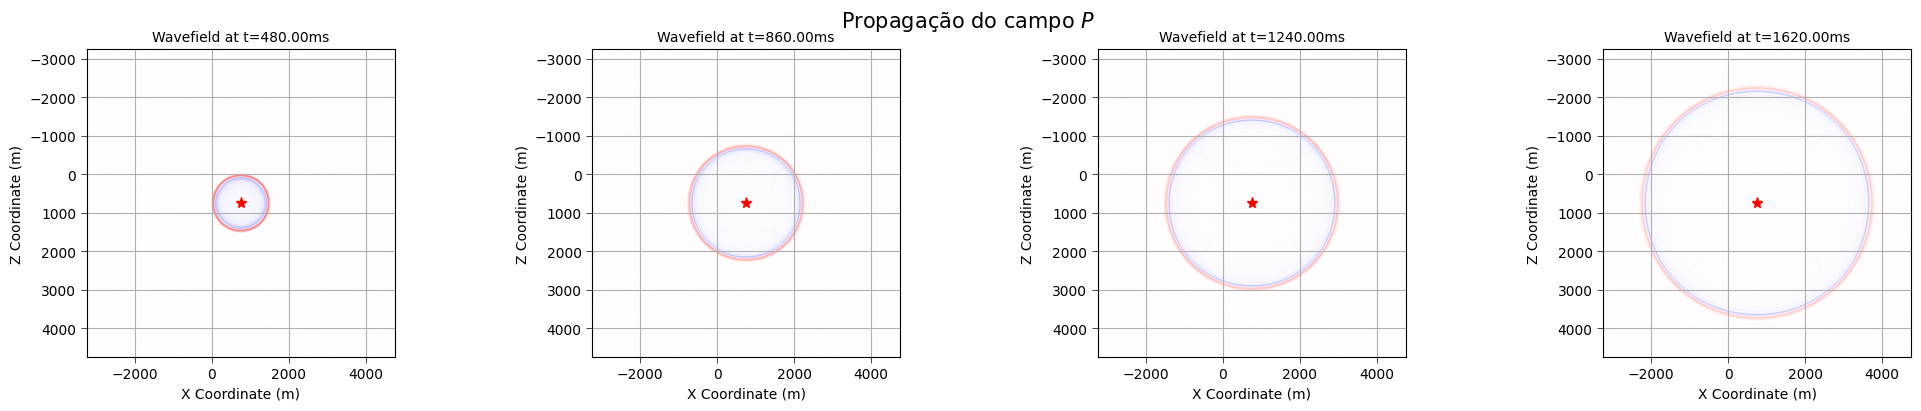

In [49]:
plot(P, title="Propagação do campo $P$")

## Resolução da alternativa c)

Devido ao princípio da conservação de energia, a energia inicial $E_0 = E(t_0)$ injetada pela fonte no meio e transportada pela onda gerada deve ser conservada. Isto significa que em todo instante $t$, tem-se que a energia total transportada pela onda é $E(t) = E_0$. A energia $e(x,z,t)$ transportada por um ponto na frente de onda é proporcional ao quadrado da sua aplitude, de forma que $e(x,z,t) = \alpha P^2(x,z,t)$ para alguma constante $\alpha$. Neste caso, no instante $t$, o campo $P$ possuirá valores não nulos apenas dentro do círculo fechado $B(t)$ de raio $R(t) = t \cdot v_P$. Logo, a energia total do sistema será

$$
\begin{aligned}
E(t) &= \int_{B(t)} e(x, z, t) ds\\
    &= e(\bar{x}_t, \bar{z}_t, t) \int_{B(t)} ds,\ \text{para algum } \bar{x}_t, \bar{z}_t \in B(t)\\
    &= e(\bar{x}_t, \bar{z}_t, t) \pi (tv_P)^2
    % &= 2\pi \int_{0}^{R(t)} e(r, t) r dr,\ \text{devido à simetria radial do campo de onda}\\
    % &= 2\pi \int_{0}^{tv_P} e(r, t) r dr,
\end{aligned}
$$
em que $e(\bar{x}_t, \bar{z}_t, t)$ é o valor médio de $e$ em $B(t)$ no instante $t$.

Num instante posterior $t'$, tem-se que $P$ possuirá valores não nulos dentro $B(t')$, de raio $R(t') = t'v_P > R(t)$:

$$
E(t') = e(\bar{x}_{t'}, \bar{z}_{t'}, t') \pi (t'v_P)^2
$$

Como $E_0 = E(t) = E(t')$,

$$
e(\bar{x}_t, \bar{z}_t, t) t^2 = e(\bar{x}_{t'}, \bar{z}_{t'}, t') t'^2
$$
$$
\begin{aligned}
\frac{e(\bar{x}_t, \bar{z}_t, t)}{e(\bar{x}_{t'}, \bar{z}_{t'}, t')} &= \frac{t'^2}{t^2}\\
    &> 1
\end{aligned}
$$

Logo,

$$
\frac{\alpha P^2(\bar{x}_t, \bar{z}_t, t)}{\alpha P^2(\bar{x}_{t'}, \bar{z}_{t'}, t')} > 1
$$
$$
P^2(\bar{x}_t, \bar{z}_t, t) > P^2(\bar{x}_{t'}, \bar{z}_{t'}, t')
$$
$$
|P(\bar{x}_t, \bar{z}_t, t)| > |P(\bar{x}_{t'}, \bar{z}_{t'}, t')|
$$

Consequentemente, o valor médio de $|P(x, z, t)|$ irá diminuir com o tempo devido ao fato que a energia do inserida no sistema pela fonte ser conservada e estar distribuida sobre uma área cada vez maior.

## Resolução da alternativa d)

### Definição da equação da onda acústica de 1ª ordem

Aqui é definida no *Devito* o sistema de equações

$$
\begin{cases}
    \dfrac{\partial \mathbf{v}}{\partial t} + \dfrac{\nabla P}{\rho} = 0\\
    \dfrac{\partial P}{\partial t} + \kappa \nabla \cdot \mathbf{v}= S
\end{cases}
$$

em que:

- $\mathbf{v}$ é o campo de velocidade da partícula;
- $\kappa = \rho v_P$ é o módulo de compressibilidade.

In [ ]:
# Função para o campo de pressão
P = TimeFunction(name="P", grid=model.grid, time_order=1, space_order=space_order, save=geometry.nt, staggered=NODE)

# Função para o campo de velocidade de partícula.
V = VectorTimeFunction(name="V", grid=model.grid, time_order=1, space_order=space_order, save=geometry.nt)

In [51]:
EDP_V = V.dt + grad(P)/rho
EDP_P = P.dt + rho*vp**2 * div(V.forward)

In [52]:
stencil_P = Eq(P.forward, solve(EDP_P, P.forward))
stencil_V = Eq(V.forward, solve(EDP_V, V.forward))

In [53]:
src_term = src.inject(field=P.forward, expr=src * dt)

### Criação do operador de diferenças finitas

In [54]:
op = Operator([stencil_V, stencil_P] + src_term, subs=model.spacing_map)

In [55]:
op(dt=dt)

Operator `Kernel` ran in 2.61 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=2.600153000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.000308000000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

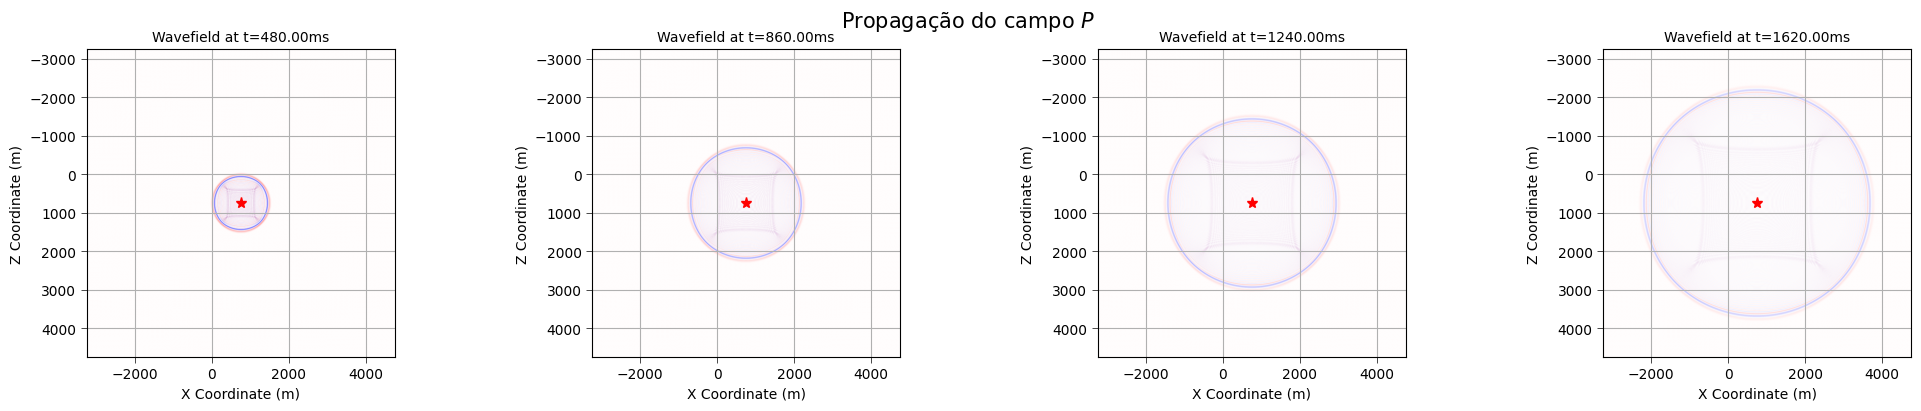

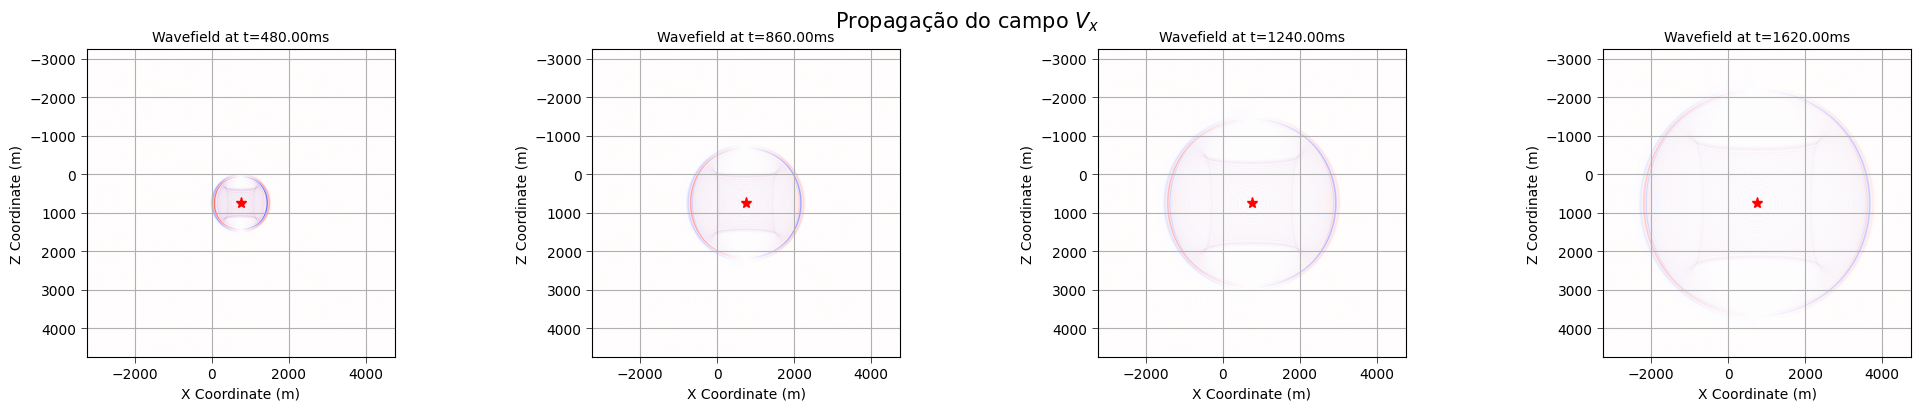

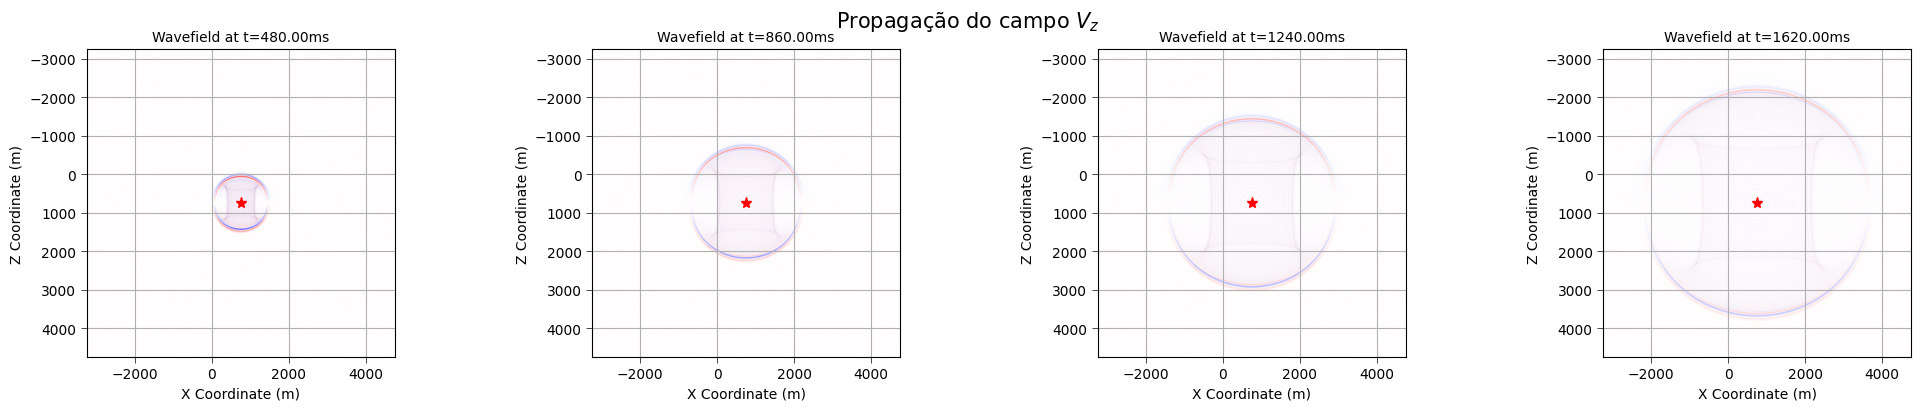

In [ ]:
plot(P, title="Propagação do campo $P$")
plot(V[0], title="Propagação do campo $V_x$")
plot(V[1], title="Propagação do campo $V_z$")